## **Diabetes Prediction**

### **Project Setup**

In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Core libraries for model development
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
# Define project paths
BASE_DIR = '/Users/youhorng/Desktop/projects/diabetes-prediction'
DATA_DIR = os.path.join(BASE_DIR, 'data')

# Define dataset path
DATASET_PATH = os.path.join(DATA_DIR, 'diabetes_data.csv')

In [4]:
# Load the dataset
df = pd.read_csv(DATASET_PATH)

### **Data Understanding**

In [ ]:
# Check the first few rows of the dataset
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [ ]:
# Check the shape of the dataset
print(f"Total number of samples: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

Total number of samples: 100000
Number of features: 9


In [8]:
# Check the basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [12]:
# Check for missing values
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [20]:
# Check for duplication
print(f"Number of duplicate rows: {df.duplicated().sum()}")

Number of duplicate rows: 3854


In [24]:
# Check the duplicated rows
df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
47708,Female,2.0,0,0,No Info,27.32,5.0,158,0
59468,Female,2.0,0,0,No Info,27.32,5.0,158,0
62073,Female,2.0,0,0,No Info,27.32,6.0,85,0
67439,Female,2.0,0,0,No Info,27.32,6.0,85,0
23617,Female,2.0,0,0,No Info,27.32,6.0,145,0


In [10]:
# Convert binary integer columns into strings
converted_columns = ["hypertension", "heart_disease", "diabetes"]
df[converted_columns] = df[converted_columns].astype(str)

In [11]:
# Check the summary statistics
df.describe(include='all')

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000,100000.000000,100000,100000,100000,100000.000000,100000.000000,100000.000000,100000
unique,3,NaN,2,2,6,NaN,NaN,NaN,2
top,Female,NaN,0,0,No Info,NaN,NaN,NaN,0
freq,58552,NaN,92515,96058,35816,NaN,NaN,NaN,91500
mean,NaN,41.885856,NaN,NaN,NaN,27.320767,5.527507,138.058060,NaN
std,NaN,22.516840,NaN,NaN,NaN,6.636783,1.070672,40.708136,NaN
min,NaN,0.080000,NaN,NaN,NaN,10.010000,3.500000,80.000000,NaN
25%,NaN,24.000000,NaN,NaN,NaN,23.630000,4.800000,100.000000,NaN
50%,NaN,43.000000,NaN,NaN,NaN,27.320000,5.800000,140.000000,NaN
75%,NaN,60.000000,NaN,NaN,NaN,29.580000,6.200000,159.000000,NaN


**Observation:** Based on the summary statistics above, we have found some interested facts.

- For features like `hypertension` and `heart_disease`, there are only 2 unique values which are yes (1) or no (0), and most of the data points are occupied with no (0) with 92K for hypertension and 96K for heart_disease.

- The target variable is `diabetes`, and according to the table above, we can see that it is very imbalanced as around 91K do not have diabetes. 

- There are some outliers that we found in features like `bmi`, and `blood_glucose_level`.

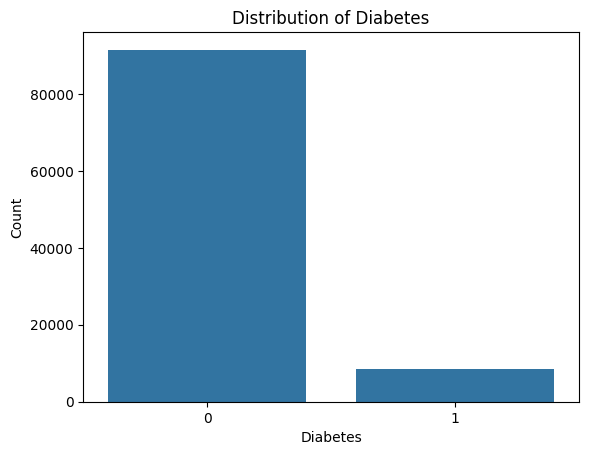

In [28]:
# Plot the distribution of the target variable
sns.countplot(x='diabetes', data=df)
plt.title('Distribution of Diabetes')
plt.xlabel('Diabetes')
plt.ylabel('Count')
plt.show()

In [25]:
# Check the outliers
def check_outliers_iqr(df, column):
    
    # Define the lower and upper bounds
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_df = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    return outliers_df, lower_bound, upper_bound

In [ ]:
# Check the outliers for all numerical features
for col in df.select_dtypes(include='number').columns:
    outliers, _, _ = check_outliers_iqr(df, col)
    print(f"{col}: {len(outliers)} outliers")

age: 0 outliers
bmi: 7086 outliers
HbA1c_level: 1315 outliers
blood_glucose_level: 2038 outliers


**Inference:** Based on the inspection above, we have found.

- There no missing values in the dataset.

- There are 3854 duplicated rows.

- There are also outliers in three numerical columns such as `bmi`, `HbA1c_level`, and `blood_glucose_level`. 

### **Data Preparation**

### **Feature Engineering**

### **Model Training**

### **Model Evaluation**